# Stability of each STATE with mean ore different single errors

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info.operators import Operator
from qiskit import execute, transpile, assemble
from qiskit import Aer
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
from sympy import factorint
from fractions import Fraction
from numpy import linalg
import pandas as pd
import numpy as np
from numpy import pi
from sympy import *
import random
import math

import qiskit.quantum_info as qi
from qiskit.visualization import array_to_latex
from qiskit.providers.aer.library import SaveDensityMatrix
from qiskit.quantum_info import Statevector

In [2]:
def errori(circuit, position, n):
    epsilon = 0.5                                                       
    extracted = random.uniform(0, 1)
    
    if (extracted < epsilon):    
        circuit.x(position)   
        circuit.barrier(range(n))
    else:
        circuit.z(position)
        circuit.barrier(range(n))
    return circuit

In [3]:
def qft_rotations(circuit, n, n_max,  case, position):
    tmp = n_max - case
    
    if n == 0:
        return circuit
    n -= 1    

    if n  == tmp:
        errori(circuit, position, n)  
        
    circuit.h(n)   
    
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)

    qft_rotations(circuit, n, n_max, case, position)

In [4]:
def swap_registers(circuit, n):
    
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)

In [5]:
def qft(circuit, n, n_max, case, position):
    if case == 1:
        errori(circuit, position, n) 

    qft_rotations(circuit, n, n_max, case, position)

    if case == n + 1:
        errori(circuit, position, n)
    swap_registers(circuit, n)    

    if case == n + 2:
        errori(circuit, position , n)
        
    if case == 0:
        pass
        
    if case > n + 2:
        print('Error: case value incorrect')
    return circuit

In [6]:
def split_circuit_by_barrier(circuit):
    qasm = circuit.qasm()
    prelude = []
    circuits = [[]]
    for line in qasm.splitlines():
        if any([line.startswith(t) for t in ['OPENQASM', 'include', 'qreg', 'creg']]):
            prelude.append(line)
        elif line.startswith('barrier'):
            break
            circuits.append([])
        else:
            circuits[-1].append(line)
    circuits_with_prelude = [prelude+circuit for circuit in circuits]
    for circuit_with_prelude in circuits_with_prelude:
        yield QuantumCircuit.from_qasm_str('\n'.join(circuit_with_prelude))

In [7]:
def split_circuit_by_error(circuit):
    qasm = circuit.qasm()
    prelude = []
    circuits = [[]]
    for line in qasm.splitlines():
        if any([line.startswith(t) for t in ['OPENQASM', 'include', 'qreg', 'creg']]):
            prelude.append(line)
        elif line.startswith('z'):
            break
        elif line.startswith('x'):
            break
            circuits.append([])
        else:
            circuits[-1].append(line)
    circuits_with_prelude = [prelude+circuit for circuit in circuits]
    for circuit_with_prelude in circuits_with_prelude:
        yield QuantumCircuit.from_qasm_str('\n'.join(circuit_with_prelude))
        

In [16]:
n = 3
repetitions = 50

amplitudes = np.empty(2**n)
summa = np.empty(2**n)
plot = []

for reps in range(repetitions):

    for case in range(n + 3):

        for position in range(n):

            control = QuantumRegister(n, 'r1')
            circuit = QuantumCircuit(control)

            qft(circuit, n, n, case, position) 
            for subcircuit in (split_circuit_by_barrier(circuit)):
                circuit_right = subcircuit
            for subcircuit in (split_circuit_by_error(circuit)):
                circuit_left = subcircuit
            circuit_right = circuit_right.inverse()
            merge = circuit_left.compose(circuit_right)

            backend = Aer.get_backend('unitary_simulator')
            job = execute(merge, backend, shots = 8192)
            result = job.result()
            UeU = result.get_unitary(merge,3)

            for iii in range(2**n):   

                label = bin(iii).lstrip('-0b').zfill(n)
                state = Statevector.from_label(label)
                amplitudes[iii] = (state.evolve(UeU)[label]**2).real
                state = 0
                summa[iii] = summa[iii] + amplitudes[iii]
           
            merge = 0
            result = 0
            circuit = 0
            UeU = 0
    reps += 1

In [17]:
for i in range(len(summa)):
    summa[i] = summa[i]/(n*repetitions*(n+3))

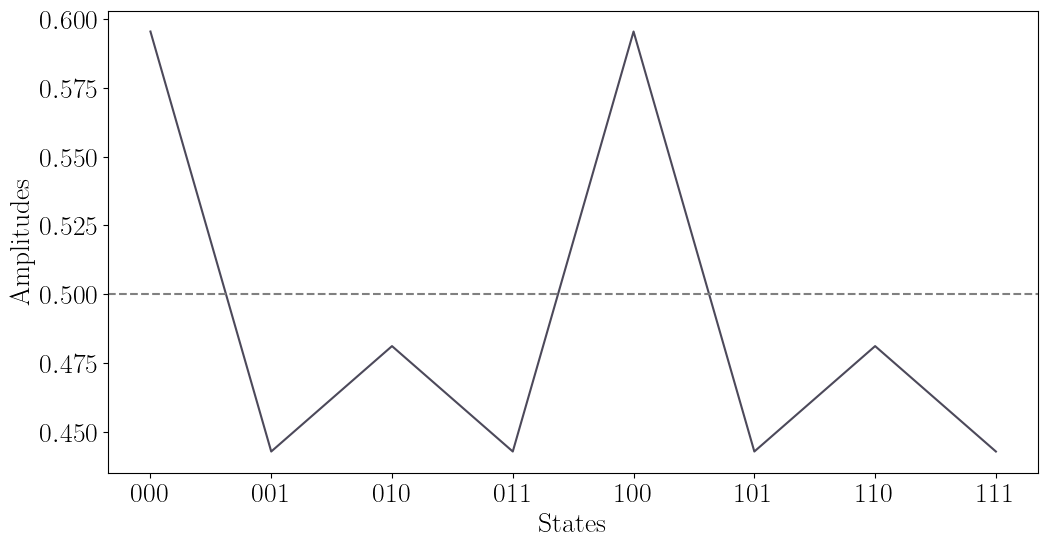

In [18]:
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 6))
params = {'text.usetex' : True, 'font.size' : 20, 'font.family' : 'serif'}
plt.rcParams.update(params)
plt.xlabel('States')
plt.ylabel('Amplitudes')

row = []
xs = []
for i in range(2**n):
    tmp = '{0:0b}'.format(i)
    tmp_list = [int(x) for x in tmp]
    while len(tmp_list) != n:
        tmp_list.insert(0, 0)
    tmp_final = ''.join(map(str, tmp_list))
    row.append(tmp_final)
    xs.append(i)

row_labels = row
plt.xticks(xs, row_labels)
plt.plot(summa, color = '#4C495A')             
plt.axhline(y=0.5, linestyle='--', color = 'grey')
plt.savefig('QFT_return_prob_states_many_errors.pdf', format = 'pdf')          